In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Define the paths
train_path = '/content/drive/My Drive/chest_xray_resized/combined_training'
test_path = '/content/drive/My Drive/chest_xray_resized/Testing'
val_path = '/content/drive/My Drive/chest_xray_resized/Validation'

# Function to check folder contents
def check_folder_contents(folder_path, folder_name):
    if os.path.exists(folder_path):
        print(f"{folder_name} Data:")
        contents = os.listdir(folder_path)
        if contents:
            print(contents)  # List the folder contents
        else:
            print(f"{folder_name} folder is empty.")
    else:
        print(f"Error: {folder_name} path does not exist.")

# Check each folder
check_folder_contents(train_path, "Train")
check_folder_contents(test_path, "Test")
check_folder_contents(val_path, "Val")


Train Data:
['NORMAL', 'PNEUMONIA']
Test Data:
['NORMAL', 'PNEUMONIA']
Val Data:
['NORMAL', 'PNEUMONIA']


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import layers, models
from plotly.subplots import make_subplots
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from PIL import Image
import plotly.offline as pyo
from IPython.display import display
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from collections import Counter
from tqdm import tqdm
import random

In [ ]:
train_dir = '/content/drive/My Drive/chest_xray_resized/combined_training'
test_dir = '/content/drive/My Drive/chest_xray_resized/Testing'
test_dir = '/content/drive/My Drive/chest_xray_resized/Validation'

In [ ]:
import os

# Paths to the directories
train_dir = '/content/drive/My Drive/chest_xray_resized/combined_training'
test_dir = '/content/drive/My Drive/chest_xray_resized/Testing'
val_dir = '/content/drive/My Drive/chest_xray_resized/Validation'

def count_images_in_folder(folder_path):
    count = 0
    for root, _, files in os.walk(folder_path):
        count += len([file for file in files if file.endswith(('jpg', 'jpeg', 'png'))])
    return count

# Count the number of images in each folder
train_images = count_images_in_folder(train_dir)
test_images = count_images_in_folder(test_dir)
val_images = count_images_in_folder(val_dir)

# Print the results
print(f"Number of images in train folder: {train_images}")
print(f"Number of images in test folder: {test_images}")
print(f"Number of images in val folder: {val_images}")


Number of images in train folder: 7693
Number of images in test folder: 624
Number of images in val folder: 16


# Data Preparation

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Parameters
img_size = 150  # Images are already resized, so this is for reference
categories = ['PNEUMONIA', 'NORMAL']  # Update to your specific categories

# Function to load images and corresponding labels
def load_images_and_labels(directory, categories):
    x_data = []
    y_labels = []

    for label, category in enumerate(categories):
        category_path = os.path.join(directory, category)
        for filename in tqdm(os.listdir(category_path), desc=f"Loading images for {category}"):
            if filename.endswith('.jpg'):
                img_path = os.path.join(category_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    x_data.append(img)
                    y_labels.append(label)

    return np.array(x_data), np.array(y_labels)

# Load the original datasets (training, validation, and test data)
x_train_combined, y_train_combined = load_images_and_labels('/content/drive/My Drive/chest_xray_resized/combined_training', categories)
x_val_combined, y_val_combined = load_images_and_labels('/content/drive/My Drive/chest_xray_resized/Validation', categories)
x_test_combined, y_test_combined = load_images_and_labels('/content/drive/My Drive/chest_xray_resized/Testing', categories)

# Combine the datasets into one
x_combined = np.concatenate((x_train_combined, x_val_combined, x_test_combined), axis=0)
y_combined = np.concatenate((y_train_combined, y_val_combined, y_test_combined), axis=0)

# Split the combined dataset into 70% training, 15% validation, and 15% test
x_train, x_temp, y_train, y_temp = train_test_split(x_combined, y_combined, test_size=0.3, random_state=42)  # 30% for validation + test
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)  # Split remaining 50% for validation and test

# Print dataset counts
print(f"Training data count: {len(x_train)}")
print(f"Validation data count: {len(x_val)}")
print(f"Test data count: {len(x_test)}")


Loading images for NORMAL: 100%|██████████| 234/234 [00:07<00:00, 32.63it/s] 


Training data count: 5833
Validation data count: 1250
Test data count: 1250


# Model Building (VGG16)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Build the model using VGG16 as the base
def build_vgg16_model(input_shape=(150, 150, 3), num_classes=2):
    # Load the VGG16 model without the top layers (include_top=False)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model layers (so they are not updated during training)
    base_model.trainable = False

    # Build the custom top layers
    model = models.Sequential()
    model.add(base_model)  # Add the base model
    model.add(layers.Flatten())  # Flatten the output
    model.add(layers.Dense(512, activation='relu'))  # Fully connected layer
    model.add(layers.Dropout(0.5))  # Dropout for regularization
    model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer

    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Instantiate and summarize the model
model = build_vgg16_model()
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,910,530 (72.14 MB)

 Trainable params: 4,195,842 (16.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Convert grayscale to RGB (3 channels)
x_train_rgb = np.repeat(x_train[..., np.newaxis], 3, axis=-1)
x_val_rgb = np.repeat(x_val[..., np.newaxis], 3, axis=-1)

# Normalize the image data to the range [0, 1]
x_train_norm = x_train_rgb / 255.0
x_val_norm = x_val_rgb / 255.0

# Train the model using the normalized data
history = model.fit(
    x_train_norm, y_train,  # Training data and labels
    epochs=5,  # Number of epochs to train
    batch_size=16,  # Batch size for training
    validation_data=(x_val_norm, y_val),  # Validation data and labels
    verbose=1  # Show training progress
)

Epoch 1/5
365/365 ━━━━━━━━━━━━━━━━━━━━ 38s 80ms/step - accuracy: 0.8845 - loss: 0.4062 - val_accuracy: 0.9672 - val_loss: 0.0784
Epoch 2/5
365/365 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9460 - loss: 0.1300 - val_accuracy: 0.9728 - val_loss: 0.0723
Epoch 3/5
365/365 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.9633 - loss: 0.0956 - val_accuracy: 0.9784 - val_loss: 0.0644
Epoch 4/5
365/365 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9658 - loss: 0.0981 - val_accuracy: 0.9784 - val_loss: 0.0619
Epoch 5/5
365/365 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.9678 - loss: 0.0904 - val_accuracy: 0.9752 - val_loss: 0.0592


In [ ]:
# After training the model
model.save('pneumonia_vgg16_model.keras')

# XAI- Gradcam

In [ ]:
def get_last_conv_layer_model(model, last_conv_layer_name):
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):  # Check if the layer is a sub-model
            sub_model = layer
            if last_conv_layer_name in [l.name for l in sub_model.layers]:
                return sub_model
    raise ValueError(f"Layer {last_conv_layer_name} not found in the model.")

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    # Extract VGG16 from the sequential model
    sub_model = get_last_conv_layer_model(model, last_conv_layer_name)
    grad_model = tf.keras.models.Model(
        [sub_model.inputs], [sub_model.get_layer(last_conv_layer_name).output, sub_model.output]
    )

    # Compute the gradient of the top predicted class for the input image
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Compute the gradient of the class channel with respect to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    # Pool the gradients over all the axes
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by its corresponding gradient importance
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def display_gradcam(img, heatmap, alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale the heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize the heatmap
    jet = plt.cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Display Grad CAM  # This block should be inside the function
    plt.figure(figsize=(5, 5))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    # Extract VGG16 from the sequential model
    sub_model = get_last_conv_layer_model(model, last_conv_layer_name)
    grad_model = tf.keras.models.Model(
        [sub_model.inputs], [sub_model.get_layer(last_conv_layer_name).output, sub_model.output]
    )

    # Compute the gradient of the top predicted class for the input image
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = tf.gather(preds[0], pred_index)

    # Compute the gradient of the class channel with respect to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    # Pool the gradients over all the axes
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by its corresponding gradient importance
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

<ipython-input-12-685f35ae62ad>:10: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



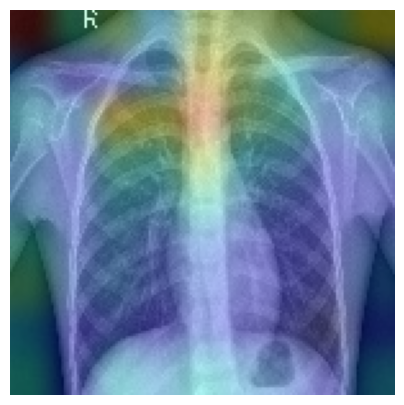

In [ ]:
# Load and preprocess an image
img_path = "/content/drive/MyDrive/chest_xray_resized/Testing/NORMAL/IM-0001-0001.jpg"
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))  # Resize to 150x150
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Ensure the input image is processed the same way as the training data
img_array = tf.keras.applications.vgg16.preprocess_input(img_array)

# Generate the Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, model, 'block5_conv3')  # Use a conv layer name from VGG16

# Display the superimposed image
display_gradcam(img_path, heatmap)

# XAI- Saliency Map

<ipython-input-15-6354fca90a99>:49: RuntimeWarning:

invalid value encountered in cast



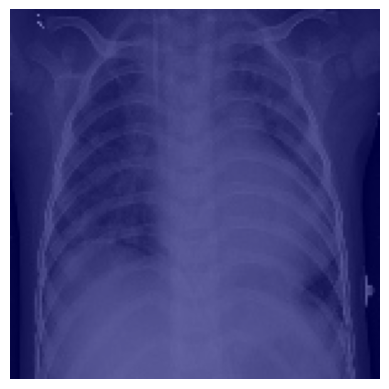

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def compute_saliency_map(model, img_array, pred_index=None):
    """
    Compute the saliency map for a given image and model.

    Args:
    - model: Trained Keras model.
    - img_array: Preprocessed image array with shape (1, height, width, channels).
    - pred_index: Index of the class for which to compute the saliency map. If None, use the top predicted class.

    Returns:
    - saliency: Saliency map as a numpy array.
    """
    img_tensor = tf.convert_to_tensor(img_array)

    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        loss = preds[:, pred_index]

    # Compute the gradient of the loss with respect to the input image
    gradients = tape.gradient(loss, img_tensor)[0]

    # Convert to grayscale by taking the maximum absolute value over the color channels
    saliency = tf.reduce_max(tf.abs(gradients), axis=-1)

    # Normalize the saliency map
    saliency = (saliency - tf.reduce_min(saliency)) / (tf.reduce_max(saliency) - tf.reduce_min(saliency))
    return saliency.numpy()

def display_saliency_map(img_path, saliency_map):
    """
    Display the saliency map superimposed on the original image.

    Args:
    - img_path: Path to the original image.
    - saliency_map: Saliency map as a numpy array.
    """
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale the saliency map to a range 0-255
    saliency_map = np.uint8(255 * saliency_map)

    # Use a heatmap color scheme
    plt.imshow(img.astype('uint8'))
    plt.imshow(saliency_map, cmap='jet', alpha=0.5)  # Overlay the saliency map with some transparency
    plt.axis('off')
    plt.show()

# Example usage:
# Load and preprocess an image
img_path = "/content/drive/MyDrive/chest_xray_resized/Testing/PNEUMONIA/person101_bacteria_485.jpg"
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))  # Resize to match model input size
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image the same way as during training
img_array = tf.keras.applications.vgg16.preprocess_input(img_array)

# Compute the saliency map
saliency_map = compute_saliency_map(model, img_array)

# Display the saliency map
display_saliency_map(img_path, saliency_map)


# XAI- SmoothGrad

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def compute_smoothgrad_heatmap(model, img_array, last_conv_layer_name, pred_index=None, num_samples=50, noise_level=0.1):
    """
    Compute the SmoothGrad heatmap for a given image and model.

    Args:
    - model: Trained Keras model.
    - img_array: Preprocessed image array with shape (1, height, width, channels).
    - last_conv_layer_name: Name of the last convolutional layer to target.
    - pred_index: Index of the class for which to compute the heatmap. If None, use the top predicted class.
    - num_samples: Number of noisy samples to average.
    - noise_level: Standard deviation of noise to add to the image.

    Returns:
    - heatmap: SmoothGrad heatmap as a numpy array.
    """
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
    smooth_grad = np.zeros_like(img_tensor.numpy())

    for _ in range(num_samples):
        noise = noise_level * np.random.normal(size=img_tensor.shape)
        noisy_img = img_tensor + noise

        with tf.GradientTape() as tape:
            tape.watch(noisy_img)
            preds = model(noisy_img)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            loss = preds[:, pred_index]

        # Compute the gradient of the loss with respect to the input image
        gradients = tape.gradient(loss, noisy_img)[0]

        # Accumulate the gradients
        smooth_grad += gradients.numpy()

    # Average the accumulated gradients
    smooth_grad /= num_samples

    # Convert to grayscale by taking the maximum absolute value over the color channels
    heatmap = tf.reduce_max(tf.abs(smooth_grad), axis=-1)

    # Normalize the heatmap
    heatmap = (heatmap - tf.reduce_min(heatmap)) / (tf.reduce_max(heatmap) - tf.reduce_min(heatmap))
    return heatmap.numpy()

In [ ]:
def display_smoothgrad_on_image(img_path, smoothgrad_map, alpha=0.4):
    """
    Display the SmoothGrad heatmap superimposed on the original image.

    Args:
    - img_path: Path to the original image.
    - smoothgrad_map: SmoothGrad heatmap as a numpy array.
    - alpha: Transparency factor for superimposition.
    """
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Squeeze the smoothgrad map to remove batch dimension
    smoothgrad_map = np.squeeze(smoothgrad_map)

    # Rescale the heatmap to a range 0-255
    smoothgrad_map = np.uint8(255 * smoothgrad_map)

    # Use a heatmap color scheme
    jet = plt.cm.get_cmap("jet")

    # Convert heatmap values to RGB colors using the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[smoothgrad_map]

    # Resize the heatmap to match the original image size
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Display the superimposed image
    plt.figure(figsize=(5, 5))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

<ipython-input-24-2e48fae98eb3>:21: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



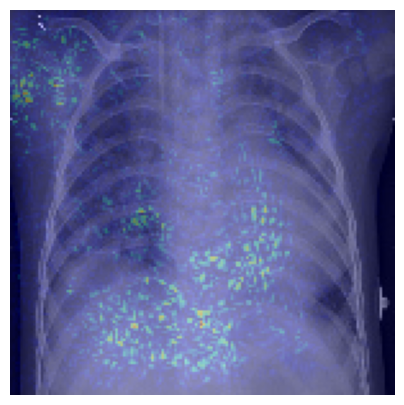

In [ ]:
# Example usage:
# Load and preprocess an image
img_path = "/content/drive/MyDrive/chest_xray_resized/Testing/PNEUMONIA/person101_bacteria_485.jpg"
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))  # Resize to match model input size
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image the same way as during training
img_array = tf.keras.applications.vgg16.preprocess_input(img_array)

# Compute the SmoothGrad heatmap
smoothgrad_map = compute_smoothgrad_heatmap(model, img_array, 'block5_conv3')  # Use the last conv layer name

# Display the SmoothGrad heatmap superimposed on the image
display_smoothgrad_on_image(img_path, smoothgrad_map)

# SmoothGrad Heatmap

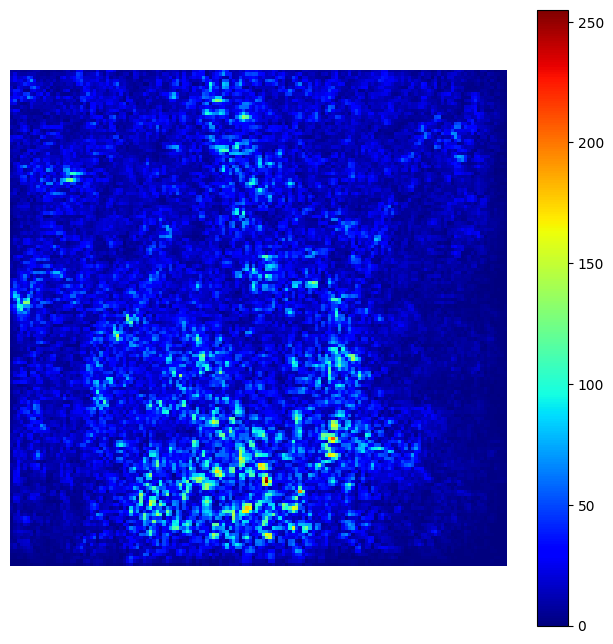

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def compute_smoothgrad_heatmap(model, img_array, last_conv_layer_name, pred_index=None, num_samples=50, noise_level=0.1):
    """
    Compute the SmoothGrad heatmap for a given image and model.

    Args:
    - model: Trained Keras model.
    - img_array: Preprocessed image array with shape (1, height, width, channels).
    - last_conv_layer_name: Name of the last convolutional layer to target.
    - pred_index: Index of the class for which to compute the heatmap. If None, use the top predicted class.
    - num_samples: Number of noisy samples to average.
    - noise_level: Standard deviation of noise to add to the image.

    Returns:
    - heatmap: SmoothGrad heatmap as a numpy array.
    """
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
    smooth_grad = np.zeros_like(img_tensor.numpy())

    for _ in range(num_samples):
        noise = noise_level * np.random.normal(size=img_tensor.shape)
        noisy_img = img_tensor + noise

        with tf.GradientTape() as tape:
            tape.watch(noisy_img)
            preds = model(noisy_img)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            loss = preds[:, pred_index]

        # Compute the gradient of the loss with respect to the input image
        gradients = tape.gradient(loss, noisy_img)[0]

        # Accumulate the gradients
        smooth_grad += gradients.numpy()

    # Average the accumulated gradients
    smooth_grad /= num_samples

    # Convert to grayscale by taking the maximum absolute value over the color channels
    heatmap = tf.reduce_max(tf.abs(smooth_grad), axis=-1)

    # Normalize the heatmap
    heatmap = (heatmap - tf.reduce_min(heatmap)) / (tf.reduce_max(heatmap) - tf.reduce_min(heatmap))
    return heatmap.numpy()

def display_heatmap(heatmap):
    """
    Display the heatmap without superimposing it on the original image.

    Args:
    - heatmap: SmoothGrad heatmap as a numpy array.
    """
    # Squeeze the heatmap to remove batch dimension
    heatmap = np.squeeze(heatmap)  # Remove the batch dimension

    # Rescale the heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Display the heatmap (make sure to handle 2D heatmaps)
    plt.figure(figsize=(8, 8))
    plt.imshow(heatmap, cmap='jet')  # Show the heatmap alone
    plt.axis('off')  # Hide the axes
    plt.colorbar()  # Optional: Add color bar to show the intensity scale
    plt.show()

# Example usage:
# Load and preprocess an image
img_path = "/content/drive/MyDrive/chest_xray_resized/Testing/PNEUMONIA/person101_bacteria_486.jpg"
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))  # Resize to match model input size
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image the same way as during training
img_array = tf.keras.applications.vgg16.preprocess_input(img_array)

# Compute the SmoothGrad heatmap
heatmap = compute_smoothgrad_heatmap(model, img_array, 'block5_conv3')  # Use the last conv layer name

# Display the heatmap alone
display_heatmap(heatmap)


# Streamlit

In [ ]:
!pip install streamlit
!pip install pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.8 MB/s eta 0:00:00


In [ ]:
import streamlit as st
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import random

# Load trained model (replace 'model_path' with your saved model path if needed)
model = tf.keras.models.load_model("pneumonia_vgg16_model.keras")

# Function to randomly select an image
def get_random_image_path(base_dir):
    category = random.choice(['NORMAL', 'PNEUMONIA'])
    folder_path = os.path.join(base_dir, category)
    image_file = random.choice(os.listdir(folder_path))
    return os.path.join(folder_path, image_file), category

# Compute Saliency Map
def compute_saliency_map(model, img_array):
    img_tensor = tf.convert_to_tensor(img_array)

    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor)
        pred_index = tf.argmax(preds[0])
        loss = preds[:, pred_index]

    gradients = tape.gradient(loss, img_tensor)[0]
    saliency = tf.reduce_max(tf.abs(gradients), axis=-1)
    saliency = (saliency - tf.reduce_min(saliency)) / (tf.reduce_max(saliency) - tf.reduce_min(saliency))
    return saliency.numpy()

# Generate Saliency Map Visualization
def generate_saliency_map(img_path, model):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
    saliency_map = compute_saliency_map(model, img_array)

    fig, ax = plt.subplots()
    ax.imshow(tf.keras.preprocessing.image.load_img(img_path).astype('uint8'))
    ax.imshow(np.uint8(255 * saliency_map), cmap='jet', alpha=0.5)
    plt.axis('off')
    return fig

# UI Layout
st.title("Pneumonia Detection and XAI Visualization")
st.write("Select a random chest X-ray image to predict if it's normal or pneumonia and explain the prediction.")

# Directory containing test images
test_dir = "/content/drive/MyDrive/chest_xray_resized/Testing"

# Button for selecting a random image
if st.button("Choose a Random Image"):
    random_image_path, actual_class = get_random_image_path(test_dir)
    img = tf.keras.preprocessing.image.load_img(random_image_path, target_size=(150, 150))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)

    # Predict image class
    prediction = model.predict(img_array)
    predicted_class = "Pneumonia" if tf.argmax(prediction[0]) == 0 else "Normal"

    # Display selected image
    st.image(random_image_path, caption=f"Selected Image: {predicted_class}", use_column_width=True)

    # Explanation and Visualizations if Pneumonia
    if predicted_class == "Pneumonia":
        st.write("### XAI Explanation for Pneumonia Prediction")

        # Saliency Map Visualization
        st.write("#### Saliency Map")
        saliency_map_fig = generate_saliency_map(random_image_path, model)
        st.pyplot(saliency_map_fig)

        st.write("**Explanation:** The saliency map highlights pixels in the image that had the greatest influence on the model's prediction.")


2025-01-13 12:49:29.222 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-13 12:49:29.397 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-01-13 12:49:29.399 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-13 12:49:29.403 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-13 12:49:29.405 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-13 12:49:29.408 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-13 12:49:29.410 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-13 12:49:29.412 Thread 'MainThread': mi

In [ ]:
from pyngrok import ngrok

# Set up a tunnel to Streamlit (use the default port 8501 for Streamlit)
public_url = ngrok.connect(8501)
print(f"Streamlit app is live at: {public_url}")

# Run the Streamlit app (replace 'app.py' with your actual script file name)
!streamlit run /content/xai_aa2-2.py

Streamlit app is live at: NgrokTunnel: "https://f4ec-34-125-127-70.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.127.70:8501



2025-01-13 12:55:16.785 Uncaught exception GET /_stcore/stream (127.0.0.1)
HTTPServerRequest(protocol='http', host='f4ec-34-125-127-70.ngrok-free.app', method='GET', uri='/_stcore/stream', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tornado/websocket.py", line 937, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/streamlit/web/server/browser_websocket_handler.py", line 126, in open
    self._session_id = self._runtime.connect_session(
  File "/usr/local/lib/python3.10/dist-packages/streamlit/runtime/runtime.py", line 384, in connect_session
    session_id = self._session_mgr.connect_session(
  File "/usr/local/lib/python3.10/dist-packages/streamlit/runtime/websocket_session_manager.py", line 99, in connect_session
    session = AppSession(
  File "/usr/local/lib/python3.10/dist-packages/streamlit/runtime/app_ses

In [ ]:
!ngrok authtoken 2rQkvHC0rnGOV35s6aiEeTxFVE5_6r4n2mk81NwcapmvufWdn


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!streamlit run "/content/xai_aa2-2.py" & npx localtunnel --port 8501

⠙

⠹⠸⠼⠴
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.124.236.11:8501

⠦your url is: https://wise-shoes-sort.loca.lt
2025-01-11 17:48:20.784 Uncaught exception GET /_stcore/stream (127.0.0.1)
HTTPServerRequest(protocol='http', host='5ac7-34-124-236-11.ngrok-free.app', method='GET', uri='/_stcore/stream', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tornado/websocket.py", line 937, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/streamlit/web/server/browser_websocket_handler.py", line 126, in open
    self._session_id = self._runtime.connect_session(
  File "/usr/local/lib/python3.10/dist-packages/streamlit/runtime/runtime.py", line 384, in connect_session
    session_id = self._session_mgr.connect_sessio

In [ ]:
!pip install pyngrok --upgrade


In [ ]:
from pyngrok import ngrok

# Open a tunnel on the streamlit default port 8501 using HTTP protocol
public_url = ngrok.connect(addr="8501", proto="http")
print(f"Streamlit Public URL: {public_url}")


Streamlit Public URL: NgrokTunnel: "https://5ac7-34-124-236-11.ngrok-free.app" -> "http://localhost:8501"
